In [6]:
import json
import os
import matplotlib.pyplot as plt

# Compute F1 score
def compute_f1(precision, recall):
    return [
        2 * (p * r) / (p + r) if p is not None and r is not None and (p + r) > 0 else None
        for p, r in zip(precision, recall)
    ]

# Load and handle different formats + missing values
def load_model_metrics(filepaths):
    models_data = {}

    for filepath in filepaths:
        with open(filepath, 'r') as f:
            history = json.load(f)

        model_name = os.path.splitext(os.path.basename(filepath))[0]

        first_entry = history[0]

        f1 = val_f1 = []

        if "precision" in first_entry:  # Keras-style
            precision = [e.get("precision") for e in history]
            recall = [e.get("recall") for e in history]
            val_precision = [e.get("val_precision") for e in history]
            val_recall = [e.get("val_recall") for e in history]

            f1 = compute_f1(precision, recall)
            val_f1 = compute_f1(val_precision, val_recall)

        elif "eval_precision" in first_entry or "eval_f1" in first_entry:  # Trainer-style
            precision = [e.get("eval_precision") for e in history]
            recall = [e.get("eval_recall") for e in history]

            if "eval_f1" in first_entry:
                f1 = [e.get("eval_f1") for e in history]
            else:
                f1 = compute_f1(precision, recall)

        else:
            print(f"⚠️ Format not recognized in: {model_name}. Skipping.")
            continue

        # Filter out None values (in case of missing data)
        f1 = [v for v in f1 if v is not None]
        val_f1 = [v for v in val_f1 if v is not None]

        models_data[model_name] = {
            'f1': f1,
            'val_f1': val_f1 if val_f1 else None
        }

    return models_data

# Plot F1 scores
def plot_f1_comparison(models_data):
    plt.figure(figsize=(12, 7))

    for model_name, metrics in models_data.items():
        epochs = range(1, len(metrics['f1']) + 1)
        plt.plot(epochs, metrics['f1'], marker='o', label=f'{model_name} - F1')

        if metrics['val_f1']:
            val_epochs = range(1, len(metrics['val_f1']) + 1)
            plt.plot(val_epochs, metrics['val_f1'], marker='s', linestyle='--', label=f'{model_name} - Val F1')

    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Over Epochs - Model Comparison')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

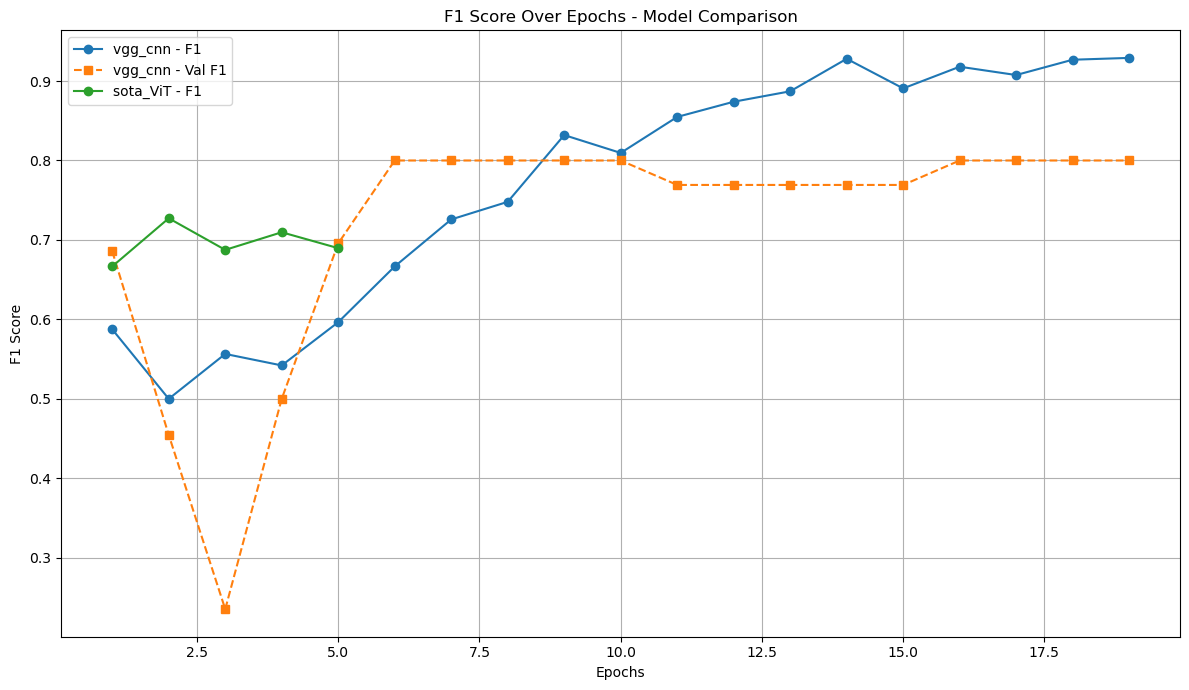

In [7]:
# Example: replace with your actual JSON file paths
json_files = [
    'vgg_cnn.json',
    'sota_ViT.json'
]

models_data = load_model_metrics(json_files)
plot_f1_comparison(models_data)